## I. MACD (Moving Average Convergence Divergence)

$MACD\ line = EMA_{26} - EMA_{12}$  
$Signal\ line = Moving\ Average\ of\ MACD_{9}$
    
Basic Strategy: 當 MACD 由上往下穿越 Signal Line，代表多頭，反之亦然。  
缺點:   
- 在 Side walk market (不是 trending) 時會給很多假信號。
- MACD 是 lagging indicator，也就是說，她的行動是比真實股價還慢的  
    
因此 MACD 通常會跟其他技術指標一起使用。

### 目標: 計算 Microsoft 的 10 年 MACD，並做成一個 function:

#### 處理數據:

In [ ]:
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ticker = "MSFT"
start = dt.datetime.today() - dt.timedelta(3650)
end = dt.datetime.today()

In [ ]:
ohlcv = yf.download(ticker, start, end)

In [ ]:
ohlcv

In [ ]:
type(ohlcv)

In [ ]:
df = ohlcv.copy() # make a copy of the original data
type(df)

In [ ]:
df["MA_Fast"] = df["Adj Close"].ewm(span=12, min_periods=12).mean() # calculate 12 days' EMA, if total day is less than 12, the value will all be NaN
df["MA_Slow"] = df["Adj Close"].ewm(span=26, min_periods=26).mean() 

In [ ]:
df["MACD"] = df["MA_Fast"] - df["MA_Slow"]
df["Signal"] = df["MACD"].ewm(span=9, min_periods=9).mean()

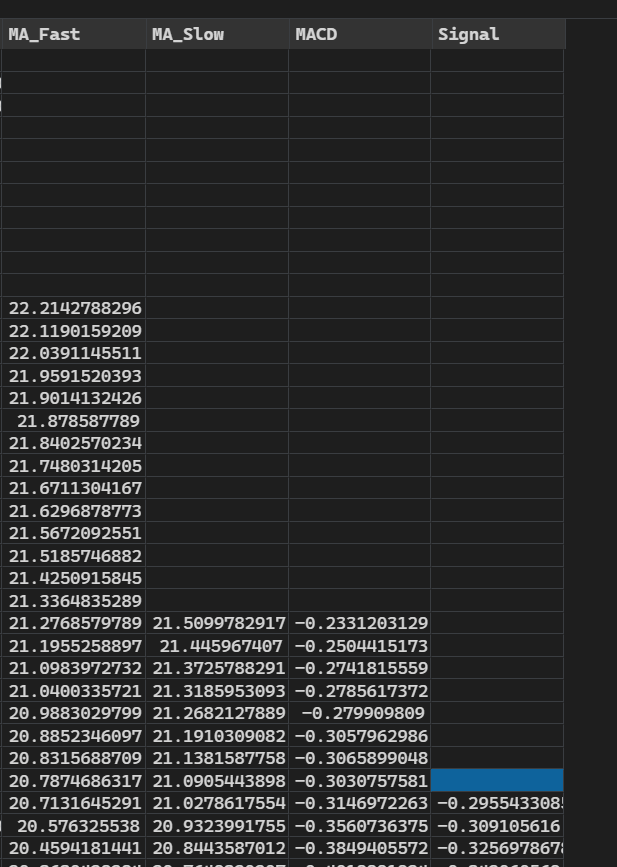

完成 MACD 的計算，注意到:  
- ```MA_Fast``` 會有 11 天的空白(12-1)    
- ```MA_Sloq``` 會有 25 天的空白(26-1)   
- ```MACD``` 會有 25 天的空白    
- ```Signal``` 會有 33 天的空白(25+(9-1))

在技術分析裡，最好不要留有 ```NaN``` 的資料，因此用 ```.dropna()``` 處理掉:

In [ ]:
df.dropna()

包成一個 function:

In [ ]:
def MACD(DF, a, b, c):
    df = DF.copy()
    df["MA_Fast"] = df["Adj Close"].ewm(span=a, min_periods=a).mean()
    df["MA_Slow"] = df["Adj Close"].ewm(span=b, min_periods=b).mean()
    df["MACD"] = df["MA_Fast"] - df["MA_Slow"]
    df["Signal"] = df["MACD"].ewm(span=c, min_periods=c).mean()
    df.dropna()
    return df

#### 資料視覺化:

In [ ]:
df.iloc[:,[4,8,9]] # 取第 4, 8, 9 column 的所有 row

In [ ]:
df.iloc[:,[4,8,9]].plot()

現在這個圖是沒有意義的，因為股票價格跟 MACD 的維度差太多。

In [ ]:
ticker = "MSFT"
start = dt.datetime.today() - dt.timedelta(10)
end = dt.datetime.today()

In [ ]:
ohlcv = yf.download(ticker, start, end)

In [ ]:
df = MACD(ohlcv, 12, 26, 9)

In [ ]:
print(df)

上面可以看到，當我只給 10 天的資料，就無法計算 MACD。因為在 MACD 的 function，我設定 min_periods 必須是 12。

## II. ATR and Bollinger bands:

這兩個指標都是在計算市場的 volatility(波動):

#### ATR:  
> 在計算ATR指標時，要先算出TR (True Range)這個數列，TR有一個明確的定義, 它指的是在以下三個數字中最大的那個數字：  
1. 今日最高價減最低價  
2. 今日最高價減昨日收盤價的絕對值  
3. 今日最低價減昨日收盤價的絕對值  
***
TR(在此指的是今天股價真正的波動範圍)之所以這樣設計的原因在於：  
1.如果今天股價跟昨天相比沒有劇烈漲跌，那麼今天的波動範圍就是今日最高價減去今日最低價  
2.如果今天大盤是跳空上漲，而且這個空沒有被回補，那麼如果還是以今高減今低當作今天價格的波動幅度，那顯然就遺漏了跳空上漲的部份，所以要將那部份加回來，所以今天TR就是今日最高價減去昨日收盤價    
3.如果今天大盤是跳空下漲，而且這個空沒有被回補，那麼如果還是以今高減今低當作今天價格的波動幅度，那顯然就遺漏了跳空下跌的部份，所以要將那部份加回來，所以今天TR就是今日最低價減去昨日收盤價的「絕對值」．注意，我們對真正的波幅都是取「正值」  
[from MoneyDj](https://www.moneydj.com/kmdj/wiki/wikiviewer.aspx?keyid=ea6bb7ee-6a9b-4ba9-ad8c-b6a1b5bc9ed4)

In [ ]:
ticker = "MSFT"
start = dt.datetime.today() - dt.timedelta(3650)
end = dt.datetime.today()

In [ ]:
ohlcv = yf.download(ticker, start, end)

In [ ]:
def ATR(DF, n):
    df = DF.copy()
    df["H-L"] = abs(df["High"] - df["Low"]) 
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1)) # 今天跳空上漲的情況
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1)) # 今天跳空下跌
    # 取三者裡的最大者，且不忽略 NaN
    df["TR"] = df[ ["H-L", "H-PC", "L-PC"] ].max(axis=1, skipna=False)
    df["ATR"] = df["TR"].rolling(n).mean() # rolling 的天數自訂，通常用 20
    # 刪除暫時的 columns
    df = df.drop( ["H-L", "H-PC", "L-PC"], axis=1)
    return df

In [ ]:
atr = ATR(ohlcv, 20)

In [ ]:
atr

In [ ]:
atr.plot()

In [ ]:
atr.iloc[:,[4,6,7]].plot()

發現時間斷太長，不好判斷:

In [ ]:
atr.iloc[-50:,[4,6,7]].plot() #  取最新的 50 天

#### Bollinger bands

就是正負兩個標準差:

In [ ]:
def BollBand(DF, n): # n 一樣是放自訂的 rolling 天數
    df = DF.copy()
    df["MA"] = df["Adj Close"].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df["MA"].rolling(n).std()
    df["BB_dn"] = df["MA"] - 2*df["MA"].rolling(n).std()
    df["BB_width"] = df["BB_up"] - df["BB_dn"] # 計算布林帶寬度
    df.dropna(inplace=True)
    return df

In [ ]:
ohlcv = yf.download(ticker, start, end)

In [ ]:
bb = BollBand(ohlcv, 20)

In [ ]:
bb.plot()

In [ ]:
bb.iloc[:,[6,7,8]].plot()

一樣天數太多不好觀察，改為 50 天:

In [ ]:
bb.iloc[-50:,[6,7,8]].plot()

其實也可以由後前數:

In [ ]:
bb.iloc[-50:,[-4,-3,-2]].plot()

## III. RSI (Relative Strength Index) 相對強弱指標:

經驗法則: RSI 大於 70: 超買，小於 30: 超賣。  
但新興市場如印度等，RSI 大於 80 才超買，小於 20 才超賣。

#### Excel implementation
因為 RSI 的計算較複雜，因此先在 ```Excel``` 做:

In [ ]:
ticker = "MSFT"
start = dt.datetime.today() - dt.timedelta(3650)
end = dt.datetime.today()

In [ ]:
ohlcv = yf.download(ticker, start, end)

In [ ]:
type(ohlcv)

In [ ]:
import os
os.getcwd()

In [ ]:
ohlcv.to_excel("c:\\Users\\User\\Quant_Trading\\MSFT_10Y_ohlcv.xlsx") # 存入指定位置，別忘記加檔名!!!

RSI 的計算方式:  
- 當某一天的收盤價比前一天的收盤價高，那就有 ```Gain```，反之，則有 ```Loss```。 (用 ```Excel``` 的 ```IF``` 達成)  
- 接著要取這些 ```Gain``` 及 ```Loss``` 的平均值 (```Avg Gain``` 與 ```Avg Loss```)，但給的權重不是一般 ```SMA```(假設取 14 天，則 ```SMA``` 第 1 天的權重等於第 14 天的權重)。RSI 會給前 13 天一樣的權重  
- 接著將 ```Avg Gain``` 除以 ```Avg Loss```，得到 ```RS```    
- RSI = 100 - (100/(1+ ```RS```))

#### Python code

以下的 code 邏輯跟 Excel 差不多:

In [ ]:
import numpy as np

In [ ]:
def RSI(DF, n):
    df = DF.copy() # copy 
    df['Delta'] = df['Adj Close'] - df['Adj Close'].shift(1) # 取得前一天收盤與今天收盤的價差
    df['Gain'] = np.where(df['Delta'] >= 0, df['Delta'], 0) # np.where() 跟 Excel 的 IF is identical
    df['Loss'] = np.where(df['Delta'] < 0, abs(df['Delta']), 0)

    # count the average gain and average loss
    avg_gain = []
    avg_loss = []
    gain = df['Gain'].tolist()
    loss = df['Loss'].tolist()
    for i in range(len(df)):
        if i < n: # if i 小於週期(eg 14 天)，則 Avg Gain 跟 Avg Loss 都會是 0(NaN)。
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['Gain'].rolling(n).mean().tolist()[n]) # .tolist(): convert a pandas Series to a list
            avg_loss.append(df['Loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append( ((n-1)*avg_gain[i-1]+gain[i])/n ) # by RSI 公式
            avg_loss.append( ((n-1)*avg_loss[i-1]+loss[i])/n )

    df['Avg Gain'] = np.array(avg_gain) # 要把 list 轉成 numpy 的 array，才可以加到 data frame 裡
    df['Avg Loss'] = np.array(avg_loss)
    df['RS'] = df['Avg Gain'] / df['Avg Loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df['RSI']

In [ ]:
rsi = RSI(ohlcv, 14)

In [ ]:
rsi # identical to the Excel file

## IV. ADX (Average Directional Index)

- 用途: 測量目前市場 trend 的強弱  
- 大小:  
    - 0-25: weak trend
    - 25-50: strong trend
    - 50-75: verty strong trend
    - 75-100: Extremely strong trend
- 只測量 trend 的"大小"，不測量 trend 的"方向"  

In [ ]:
ticker = "AAPL"
start = dt.datetime.today() - dt.timedelta(365) # one year period
end = dt.datetime.today()

In [ ]:
ohlcv = yf.download(ticker, start, end)

In [ ]:
os.getcwd()

In [ ]:
ohlcv.to_excel("c:\\Users\\User\\Quant_Trading\\AAPL_1Y_ohlcv.xlsx")

ADX 的計算:

步驟:  
- 藉由比較 今日high-今日low, 今日high-昨日收盤價, 今日low-昨日收盤價，得出 True Range (```TR```)  
- 計算 ```DM+``` 與 ```DM-```:  
    - 如果 今日high-昨日high 比 昨日low-今日low 大，代表今日總體而言上升趨勢較大:
        - 如果 今日high 比 昨日high 大，則 ```DM+``` 為 今日high-昨日high，否則為 0。 註:也就是高點越來越高   
    - 如果 昨日low-今日low 比 今日high-昨日high 大，代表今日總體而言下降趨勢較大:  
        - 如果 昨日low 比 今日high 大，則 ```DM-``` 為 昨日low-今日low，否則為 0。 註:也就是低點越來越低   
- 如果 period 為 14，則計算 ```TR```, ```DM+```, ```DM-``` 的 14 日 rolling average，分別為 ```TR14```, ```DM+_14```, ```DM-_14```。   
- 分別計算 ```DM+_14``` 與 ```TR14```的比值，```DM-_14``` 與 ```TR14```的比值，得出 ```DI+``` 與 ```DI-```。 註:```DM+_14``` 代表高者更高的那個值，但要除以波動(以 True Range 代表)
- 計算每日的 ```DI+``` 與 ```DI-``` 的合，與兩者之差，得出 ```DI_Sum``` 與 ```DI_Diff```。 
- 將 ```DI_Diff``` 除以 ```DI_Sum```，得出每日的 ```DX```。  
- 再對 ```DX``` 取 14 日 rolling，即為 ```ADX```。   


對應之 ```Excel``` 函數:
- ```TR```: ```=MAX(C3-D3, ABS(C3-E2), ABS(D3-E2))```  
- ```DM+```, ```DM-```: ```=IF(C3-C2>D2-D3, MAX(C3-C2, 0), 0)```, ```=IF(D2-D3>C3-C2, MAX(D2-D3, 0), 0)```    
- ```TR14```, ```DM+_14```, ```DM-_14```: ```=SUM(F3:F15)``` (第一個 rolling), ```=I16-(I16/14)+F17``` (之後的 rolling)  
- ```DI+```, ```DI-```: ```=100*(J16/I16)```  
- ```DI_Diff```, ```DI_Sum```: ```=L16+M16```, ```=ABS(L16-M16)```  
- ```DX```: ```=100*(O16/N16)```  
- ```ADX```: ```=AVERAGE(P16:P29)``` (第一個 rolling), ```=(Q29*13+P30)/14``` (之後的 rolling)


#### Python code:

In [ ]:
import numpy as np

In [ ]:
def ATR(DF, n): # ATR function from previous content
    df = DF.copy()
    df["H-L"] = abs(df["High"] - df["Low"]) 
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1)) # 今天跳空上漲的情況
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1)) # 今天跳空下跌
    # 取三者裡的最大者，且不忽略 NaN
    df["TR"] = df[ ["H-L", "H-PC", "L-PC"] ].max(axis=1, skipna=False)
    df["ATR"] = df["TR"].rolling(n).mean() # rolling 的天數自訂，通常用 20
    # 刪除暫時的 columns
    df = df.drop( ["H-L", "H-PC", "L-PC"], axis=1)
    return df['TR']
def ADX(DF, n):
    df2 = DF.copy()
    df2['TR'] = ATR(df2, n) # 直接帶入已寫好的公式
    
    # Calculate DM+
    df2['DMplus'] = np.where(df2['High']-df2['High'].shift(1) > df2['Low'].shift(1)-df2['Low'], df2['High']-df2['High'].shift(1), 0)
    df2['DMplus'] = np.where(df2['DMplus'] > 0, df2['DMplus'], 0)

    # Calculate DM-
    df2['DMminus'] = np.where(df2['Low'].shift(1)-df2['Low'] > df2['High']-df2['High'].shift(1), df2['Low'].shift(1)-df2['Low'], 0)
    df2['DMminus'] = np.where(df2['DMminus'] > 0, df2['DMminus'], 0)

    # Give the empty lists to get TR, DM+, DM- periods
    TRn = []
    DMplusN = []
    DMminusN = []

    # need these datas to calculate TR14+, DM+_14, DM-_14
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:    
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append( TRn[i-1]- (TRn[i-1]/n) + TR[i] )
            DMplusN.append( DMplusN[i-1] - (DMplus[i-1]/n) + DMplus[i])
            DMminusN.append( DMminusN[i-1] - (DMminus[i-1]/n) + DMminus[i])
    # dont forget to change list to np.array to merge into the data frame
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)

    # calculate DI+, DI-
    df2['DIplusN'] = (df2['DMplusN'] / df2['TRn'])*100
    df2['DIminusN'] = (df2['DMminusN'] / df2['TRn'])*100

    # calculate DI+_Sum, DI-_Diff
    df2['DIsum'] = df2['DIplusN'] + df2['DIminusN']
    df2['DIdiff'] = abs(df2['DIplusN'] - df2['DIminusN'])

    # calculate DX
    df2['DX'] = (df2['DIdiff']/df2['DIsum']) * 100

    # calculate ADX (need to loop again)
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1: # if n=14 -> 2*n-1=27，也就是 ADX 的第一個值會在第27天
            ADX.append(np.NaN)
        elif j == 2*n-1: # 第27天時，ADX 是取第14天(now j=27, so 14=j+1-n)到第27天(28=j+1)的 DX 之平均
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append((ADX[j-1]*(n-1)+DX[j])/n)
    df2['ADX'] = np.array(ADX)
    return df2['ADX']


In [ ]:
ticker = "AAPL"
start = dt.datetime.today() - dt.timedelta(365) # one year period
end = dt.datetime.today()

In [ ]:
ohlcv = yf.download(ticker,start, end)

In [ ]:
ohlcv.shape

In [ ]:
adx = ADX(ohlcv, 14)

In [ ]:
adx

## V. OBV (On Balance Volume)

- 是一個 momentum indicator (測量成交量)  
- 上升中的 OBV 代表未來股價可能上升，反之亦然。  
- 是一個 leading market indicator (領先指標) <-> MACD 是 lagging indicator，通常交易策略會用 領先+落後指標為組合  
- OBV 公式:  
    - 如果今天收盤價 > 昨日收盤價: 今日 OBV = 昨日 OBV + 今日交易量 (volume)
    - 如果今天收盤價 < 昨日收盤價: 今日 OBV = 昨日 OBV - 今日交易量 (volume)
    - 如果今天收盤價 = 昨日收盤價: 今日 OBV = 昨日 OBV

In [88]:
ticker = "AAPL"
start = dt.datetime.today() - dt.timedelta(365) # one year period
end = dt.datetime.today()

In [89]:
ohlcv = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [91]:
os.getcwd()

'c:\\Users\\User\\Quant_Trading'

In [94]:
ohlcv.to_excel("c:\\Users\\User\\Quant_Trading\\AAPL_1Y_ohlcv_obv.xlsx")

#### Excel Implementation:

- 得出 ```Direction```: ```=IF(E3>E2, 1, -1)``` (如果今日收盤價大於昨日收盤價，則設為 1，否則為 -1)  
- 得出 ```Vol*dr```: 就是成交量 * ```Direction``` column  
- 得出 ```OBV```: ```=SUM($H$2:H3)```。 因為是 cumulative sum，所以必須要固定第一天的 OBV。

#### python code:

In [95]:
def OBV(DF):
    df = DF.copy()
    # 用 data frame 的 .pct_change() 來看今日收盤是否大於昨日收盤
    df['Daily Return'] = df['Adj Close'].pct_change() 
    # dont forget np.where() is identical to Excel's IF function
    df['Direction'] = np.where(df['Daily Return']>0, 1, -1)
    df['Direction'][0] = 0 # 第一天的 OBV 必須是 0
    df['Vol Adjusted'] = df['Direction'] * df['Volume']
    df['OBV'] = df['Vol Adjusted'].cumsum() # use .cumsum() to calculate cumulative sum
    
    return df['OBV'] # return a series

In [96]:
obv = OBV(ohlcv)

In [97]:
obv

Date
2020-01-27             0
2020-01-28     162234000
2020-01-29     378463200
2020-01-30     251720000
2020-01-31      52131600
                 ...    
2021-01-19     769056900
2021-01-20     873376400
2021-01-21     993905900
2021-01-22    1108365300
2021-01-25    1265647700
Name: OBV, Length: 252, dtype: int64